**성능 향상 튜토리얼**

**1. Introduction**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

**2. Load and Check Data**

*2.1 Load Data*

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/brAIns 22년도 (1학기)/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/brAIns 22년도 (1학기)/test.csv')
IDtest = test['PassengerId']

*2.2 Outlier Detection*

In [ ]:
# Turkey의 범위 검정 개념을 이요해서 Age, SibSp, Parch, Fare에 대한 이상치 분석

features = ['Age', 'SibSp', 'Parch', 'Fare']
def detect_outliers(df, n, features):
  outlier_indices =[]
  for col in features:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outlier_list_col = df[(df[col]<Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
    outlier_indices.extend(outlier_list_col)
  
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)

  return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, features)
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
trian = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

*2.3 Joining Train and Test Set*

In [ ]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# concat()은 데이터 속성 형태가 동일한 데이터 세트를 합칠 때 사용한다. axis가 0이면 위, 아래로 axis가 1이면 좌, 우로 합친다.

*2.4 Check for Null and Missing Values*

In [ ]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**3. Feature Analysis**

*3.1 Numerical values*


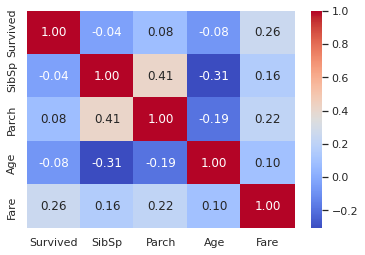

In [ ]:
# 상관관계 분석

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

SibSp

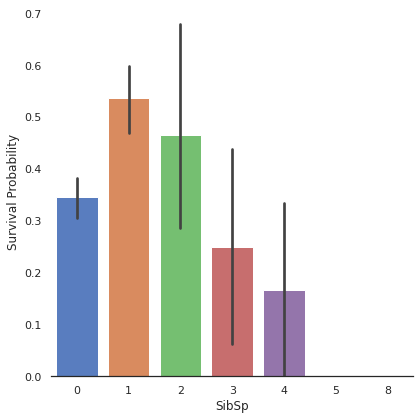

In [ ]:
g = sns.factorplot('SibSp', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

Parch

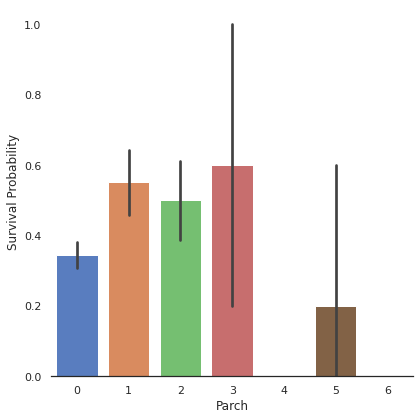

In [ ]:
g = sns.factorplot('Parch', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

Age

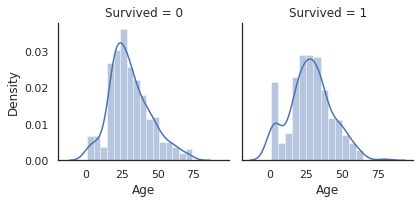

In [ ]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

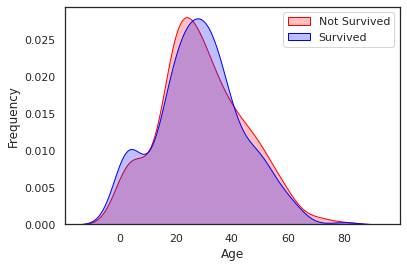

In [ ]:
g = sns.kdeplot(trian['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Not Survived', 'Survived'])

Fare

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

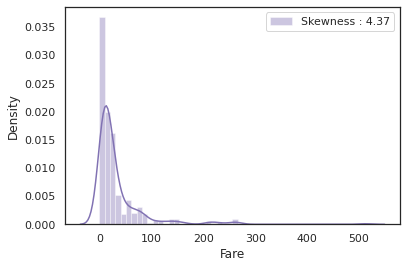

In [ ]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

In [ ]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

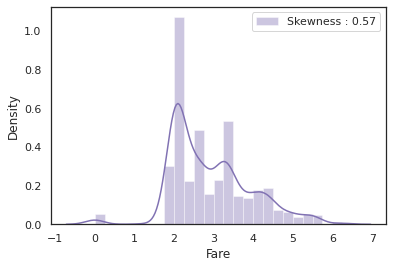

In [ ]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

*3.2 Categorical Values*

Text(0, 0.5, 'Survival Probability')

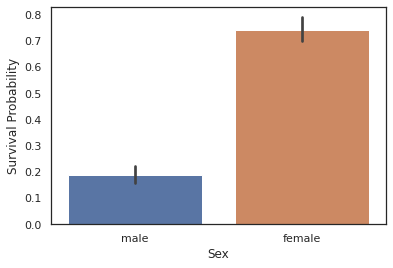

In [ ]:
g = sns.barplot('Sex', 'Survived', data=train)
g.set_ylabel('Survival Probability')

In [ ]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Pclass

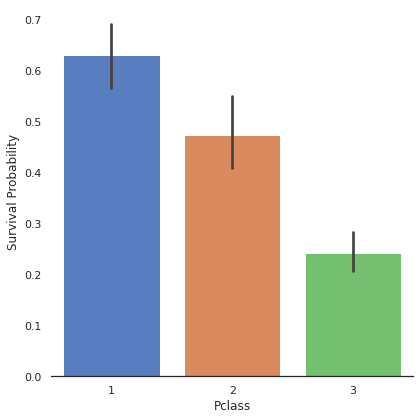

In [ ]:
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

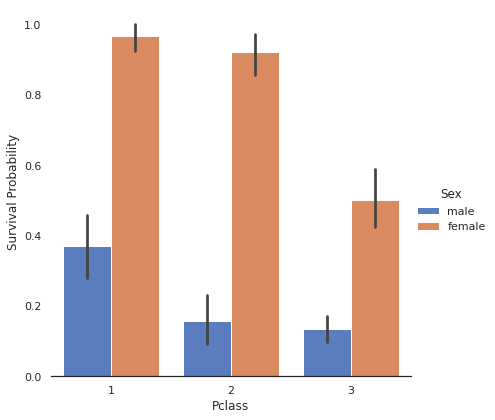

In [ ]:
g = sns.factorplot('Pclass', 'Survived', hue='Sex', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

Embarked

In [ ]:
dataset['Embarked'].isnull().sum()

2

In [ ]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

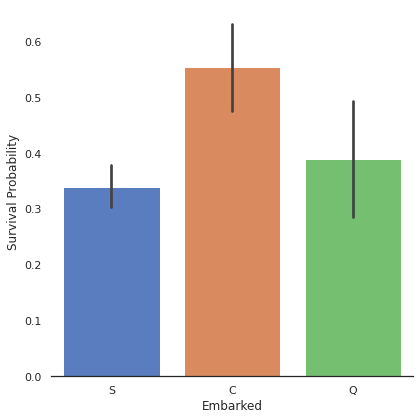

In [ ]:
g = sns.factorplot('Embarked', 'Survived', data=trian, size=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

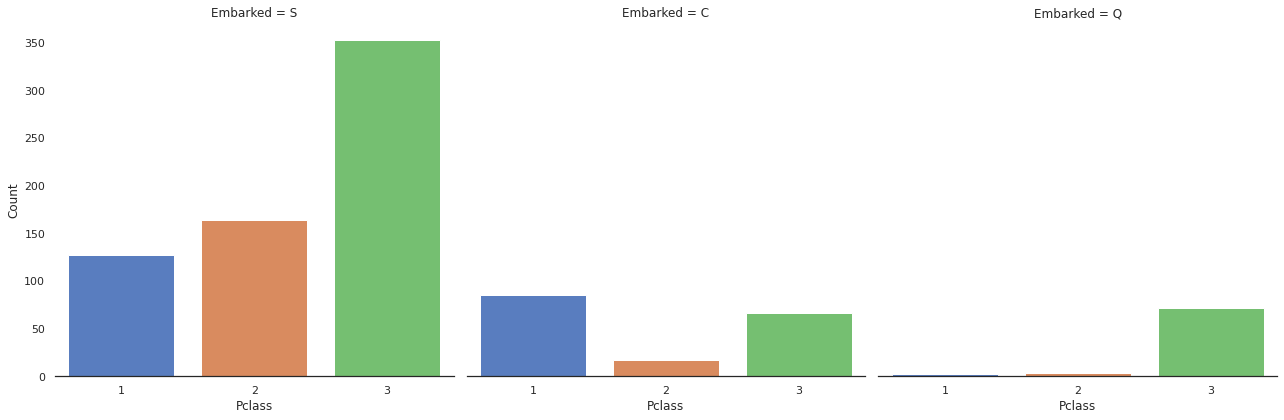

In [ ]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g.set_ylabels('Count')

**4. Filling Missing Values**

*4.1 Age*

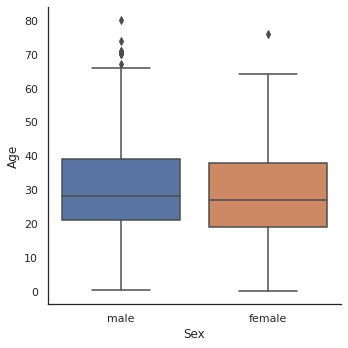

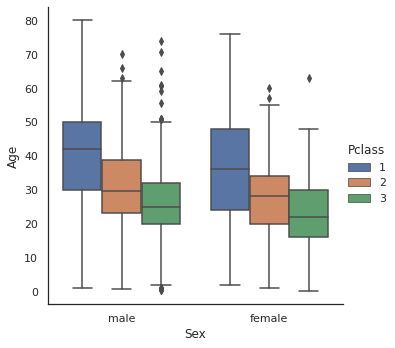

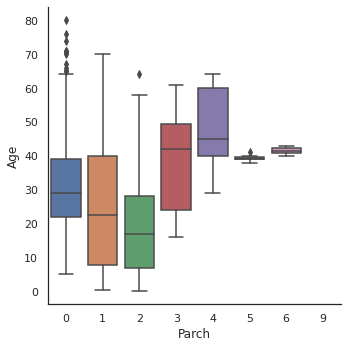

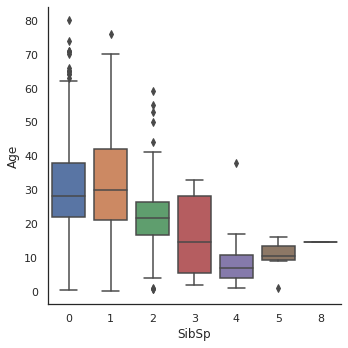

In [ ]:
sns.factorplot('Sex', 'Age', data=dataset, kind='box')
sns.factorplot('Sex', 'Age', hue='Pclass', data=dataset, kind='box')
sns.factorplot('Parch', 'Age', data=dataset, kind='box')
sns.factorplot('SibSp', 'Age', data=dataset, kind='box')

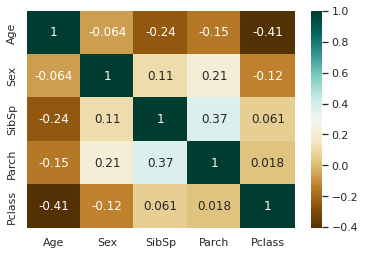

In [ ]:
#성별이 문자형 데이터이므로 숫자형으로 변환하고 상관관계 분석 

dataset['Sex'] = dataset['Sex'].map({"male": 0, "female": 1})
sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [ ]:
# 상관관계가 있다고 나온 SibSp, Parch, Pclass를 이용해서 Age의 Null 값 채우기

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
  if np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_med
  else:
    dataset['Age'].iloc[i] = age_pred

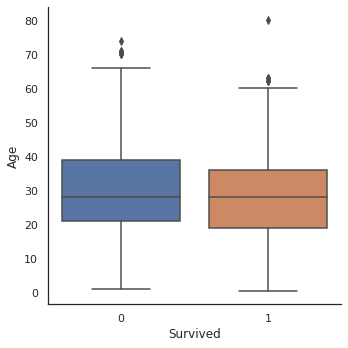

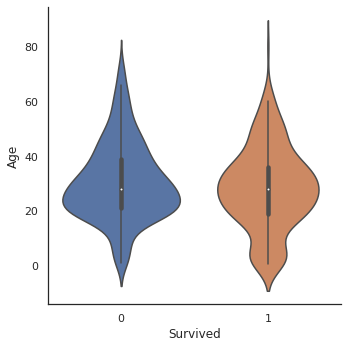

In [ ]:
sns.factorplot('Survived', 'Age', data=train, kind='box')
sns.factorplot('Survived', 'Age', data=train, kind='violin')

**5. Feature Engineering**

*5.1 Name/Title*

In [ ]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

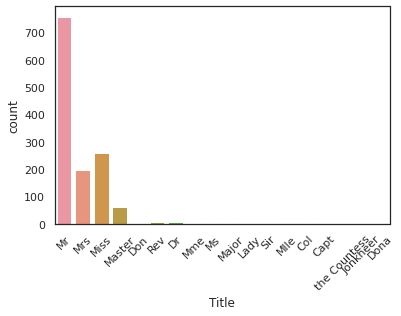

In [ ]:
g = sns.countplot('Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [ ]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms":1, "Mme": 1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

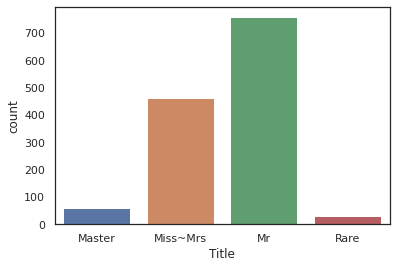

In [ ]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss~Mrs', 'Mr', 'Rare'])

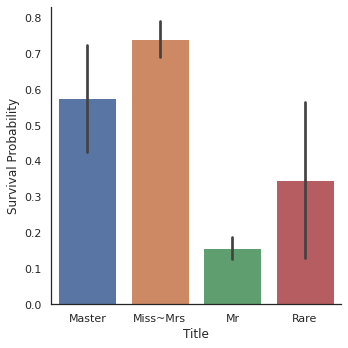

In [ ]:
g = sns.factorplot('Title', 'Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss~Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

In [ ]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

*5.2 Family Size*

In [ ]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

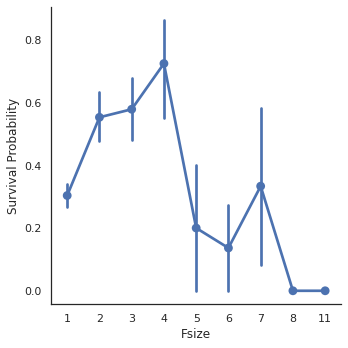

In [ ]:
g = sns.factorplot('Fsize', 'Survived', data=dataset)
g.set_ylabels('Survival Probability')

In [ ]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >=5 else 0)

Text(0, 0.5, 'Survival Probability')

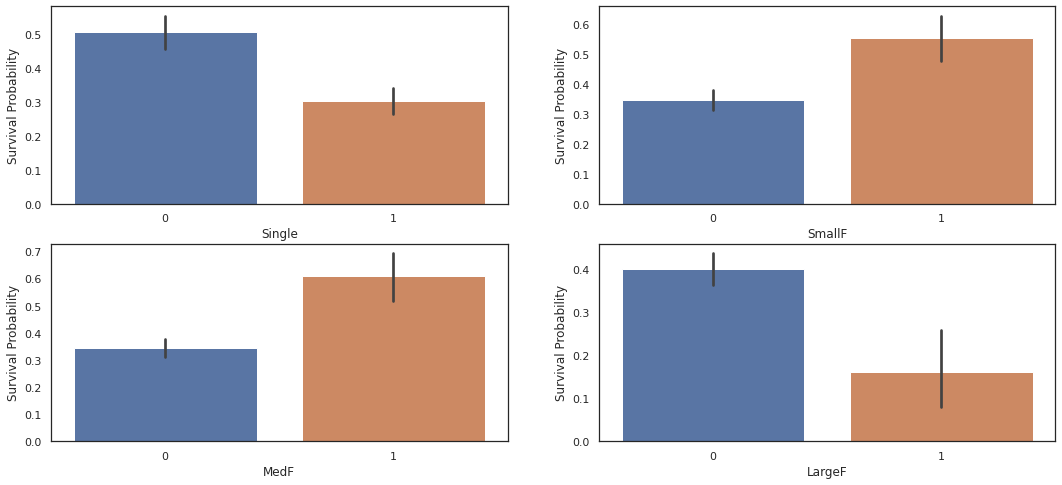

In [ ]:
f, ax = plt.subplots(2,2, figsize=(18,8))
sns.barplot('Single', 'Survived', data=dataset, ax=ax[0,0])
ax[0,0].set_ylabel('Survival Probability')
sns.barplot('SmallF', 'Survived', data=dataset, ax=ax[0,1])
ax[0,1].set_ylabel('Survival Probability')
sns.barplot('MedF', 'Survived', data=dataset, ax=ax[1,0])
ax[1,0].set_ylabel('Survival Probability')
sns.barplot('LargeF', 'Survived', data=dataset, ax=ax[1,1])
ax[1,1].set_ylabel('Survival Probability')

In [ ]:
#Title 과 Embarked에 One-Hot Encoding

dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


*5.3 Cabin*

In [ ]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].isnull().sum()

1014

In [ ]:
# Cabin의 앞 글자(알파벳)에 따른 생존률 파악

dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

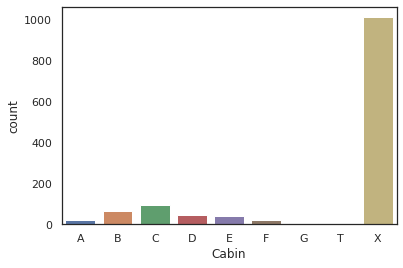

In [ ]:
sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

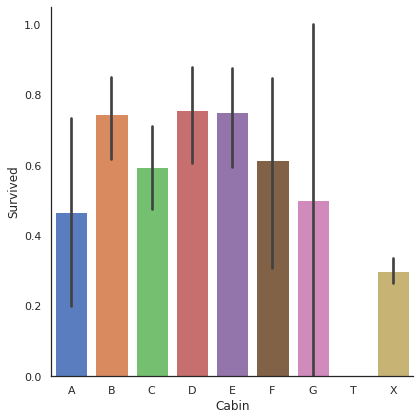

In [ ]:
g = sns.factorplot('Cabin', 'Survived', data=dataset, kind='bar', size=6, palette='muted', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

In [ ]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


*5.4 Ticket*

In [ ]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [ ]:
# Ticket의 숫자부분보다 앞부분이 더 맣은 정보를 가지고 있을 것이라 판단하고 앞글자만 추출
# isalpha: 문자열이 아닌지를 True, False로 리턴
# isdigit: 숫자인지 아닌지를 True, False로 리턴
# strip: 양쪽의 공백 제거

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.', '').replace('/','').strip().split(' ')[0])
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
# Ticket과 Pclass에 대해 One-Hot encoding을 진행
# Pclass는 categorical value로 변경해주고 PassengerID는 삭제

dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


**6. Modeling**

In [ ]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

*6.1 Simple modling*

6.1.1 Cross Validate Models

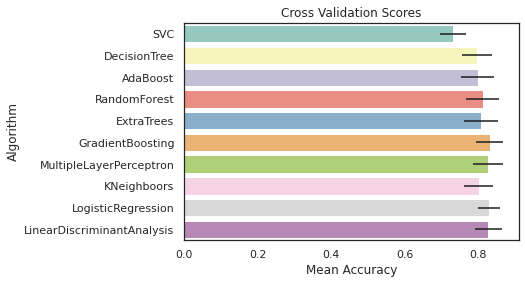

In [ ]:
# 유명한 10개의 분류기를 비교하고 Stratified KFold로 교차검증을 진행

kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ["SVC","DecisionTree","AdaBoost",
                                                                                          "RandomForest","ExtraTrees","GradientBoosting",
                                                                                          "MultipleLayerPerceptron","KNeighboors",
                                                                                          "LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

# 필자는 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting을 앙상블 모델링을 위해 선택

6.1.2 Hyperparameter Tunning for Best Models

In [ ]:
# AdaBoost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME', 'SAMME.R'],
                 'n_estimators': [1, 2],
                 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
# verbose=0(default)면 메시지 출력 안함, 1이면 간단한 메시지 출력, 2면 하이퍼 파라미터별 메시지 출력
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8159675405742821

In [ ]:
# ExtraTrees

ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8327840199750313

In [ ]:
# RandomForest

RFC = RandomForestClassifier()
rf_param_grid = {'max_depth': [None],
                 'max_features': [1, 3, 10],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [False],
                 'n_estimators': [100, 300],
                 'criterion': ['gini']}
gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8372659176029963

In [ ]:
# GradientBoosting

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.832796504369538

In [ ]:
# SVC

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8327840199750313

6.1.3 Plot Learning Curves

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

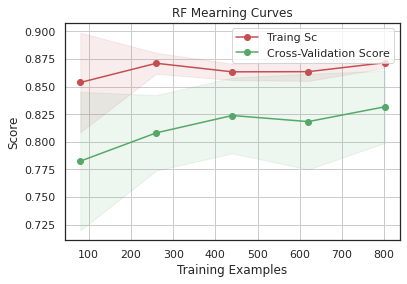

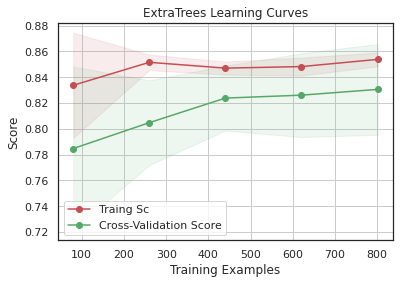

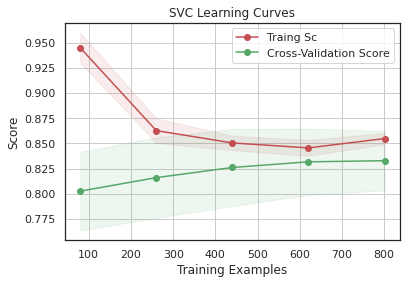

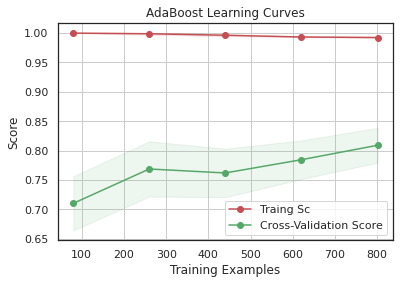

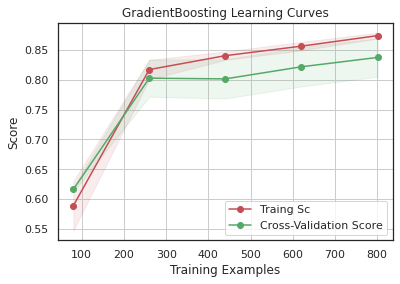

In [ ]:
# Learning Curve는 훈련세트에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인하기 좋은 방법이다. 
# np.linspace(시작값, 끝값, 갯수) 갯수 안쓰면 50개

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training Examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

# 그래프에 격자 표시 넣기
  plt.grid()
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Traing Sc')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label = 'Cross-Validation Score')
  plt.legend(loc='best')

  return plt

plot_learning_curve(gsRFC.best_estimator_, 'RF Mearning Curves', X_train, Y_train, cv=kfold)
plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsSVMC.best_estimator_, "SVC Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting Learning Curves", X_train, Y_train, cv=kfold)

In [ ]:
# GradientBoosting과 AdaBoost에서 과적합 경향을 보이고 SVC와 ExtraTrees는 Training Score와 Cross-Validation Score가 가까워서 예측을 더 일반화하는 것으로 보임

6.1.4 Feature Importance of tree based classifiers

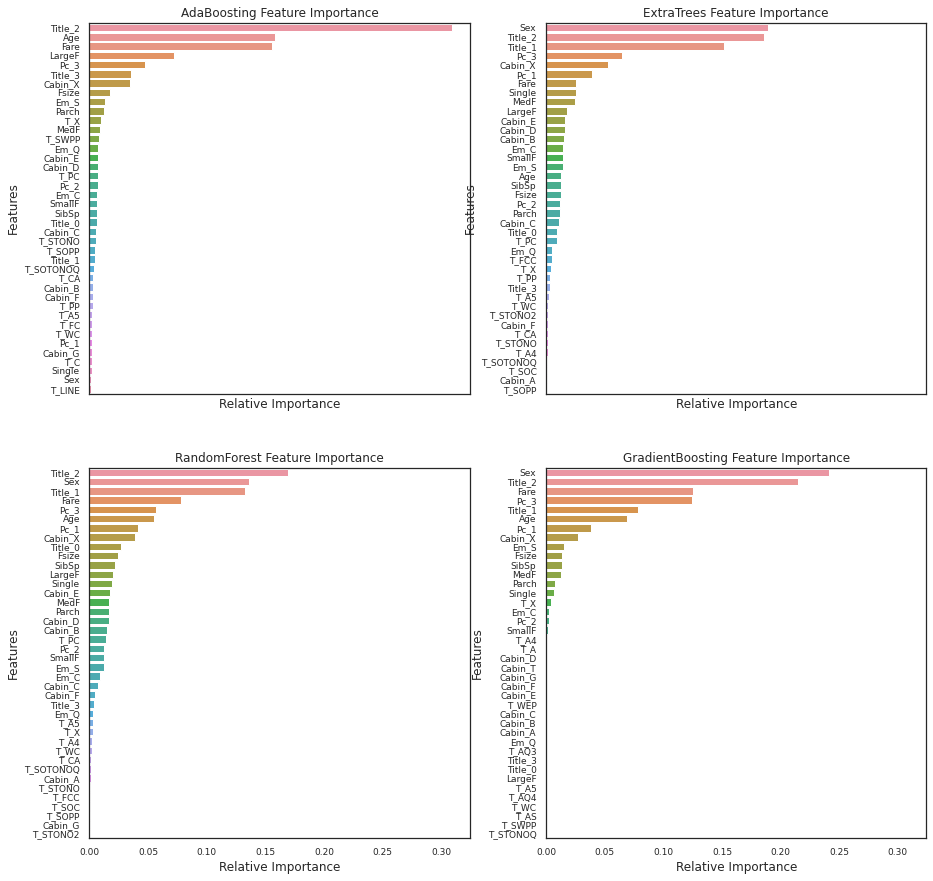

In [ ]:
nrows = ncols = 2
f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))
names_clssifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier=0
for row in range(nrows):
  for col in range(ncols):
    name = names_clssifiers[nclassifier][0]
    classifier = names_clssifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=ax[row][col])
    g.set_xlabel('Relative Importance', fontsize=12)
    g.set_ylabel('Features', fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name+' Feature Importance')
    nclassifier += 1

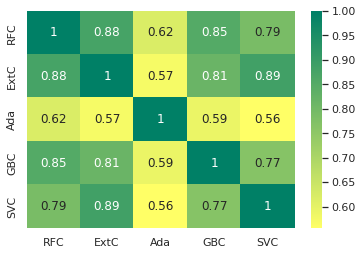

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)
sns.heatmap(ensemble_results.corr(), annot=True, cmap='summer_r')

*6.2 Ensemble modeling*

In [ ]:
# VotingClassifier는 다수결 분류로 두가지 방법이 가능하다. (5가지 분류기가 있을때를 가정)
# hard voting: 1이라고 예측한 분류기가 3개, 0이라고 예측한 분류기가 2개라면 1을 채택한다. => 과반수 투표
# soft voting: 각 분류기의 예측을 평균내어 예측 확률에 대한 평균이 높게 나오는 클래스를 최종 예측 클래스로 정한다.
# 여기선 soft voting 방식을 사용한다.

votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

*6.3 Prediction*

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('titanic_with_ensemble_modeling.csv', index=False)